# The Titanic Dataset
#### The task is to use the Titanic dataset to build a classifier that can predict whether someone survived the Titanic crash given some attributes.

### Obtaining the dataset

In [109]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [110]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [111]:
def load_titanic_data(train_or_test):
    '''
    Returns a pandas dataframe containing the Titanic data
    '''
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return pd.read_csv(Path(f"datasets/titanic/{train_or_test}.csv"))

### Separating into Train and Test Set
### Along with some Exploratory Data Analysis (EDA)

In [112]:
X_train = load_titanic_data("train")

In [113]:
print(f"The shape of the training data: {X_train.shape}.")

The shape of the training data: (891, 12).


In [114]:
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


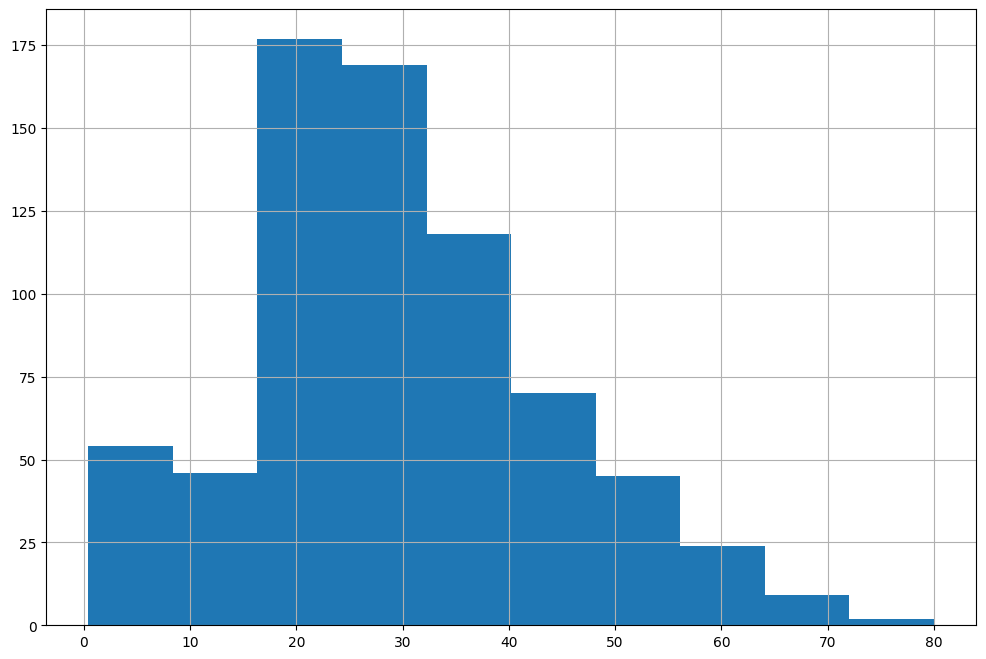

In [115]:
import matplotlib.pyplot as plt

X_train["Age"].hist(bins=10, figsize=(12, 8))
plt.show()

In [116]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Since we notice that there are missing age values, let us impute. 
- I want to use the median age for passengers of that Pclass and Gender.
- e.g. if there is no age for a female in first class, I will set her age to be the median of all females in first class. 

In [117]:
# Calculate the median age by each Pclass-gender group
df_median_age = X_train.groupby(["Sex", "Pclass"])["Age"].median().reset_index()
df_median_age = df_median_age.rename(columns={"Age" : "median_age"})
print(df_median_age)

      Sex  Pclass  median_age
0  female       1        35.0
1  female       2        28.0
2  female       3        21.5
3    male       1        40.0
4    male       2        30.0
5    male       3        25.0


In [118]:
# Next we want to merge the median ages as a new column into the original dataframe
X_train = pd.merge(X_train, df_median_age, on=["Sex", "Pclass"], how="left")
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,median_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,25.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,21.5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,25.0


In [119]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  median_age   891 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


In [120]:
# Finally, we replace any null ages with the median age and then drop the median_age column
X_train["Age"] = X_train.apply(
    lambda row: row["median_age"] if pd.isnull(row["Age"]) else row["Age"], axis=1
)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  median_age   891 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


In [121]:
X_train = X_train.drop(columns=["median_age"])

#### Training Data Summary
- A large percentage of passengers are between 20 and 30
- There are 577 males and 314 females
- The majority of tickets are 3rd class tickets
- So when splitting the data into training and validation, we may want to stratify on the these 3 categories. We can combine them to create the classes:
    - `male_child_c1` : a male below the age of 18 with a first class ticket
    - `male_youngAdult_c1` : a male between 18 and 35 (inclusive) with a first class ticket
    - `male_adult_c1` : a male between over 35 with a first class ticket

    - `male_child_c2` : a male below the age of 18 with a second class ticket
    - `male_youngAdult_c2` : a male between 18 and 35 (inclusive) with a second class ticket
    - `male_adult_c2` : a male between over 35 with a second class ticket

    - `male_child_c3` : a male below the age of 18 with a third class ticket
    - `male_youngAdult_c3` : a male between 18 and 35 (inclusive) with a third class ticket
    - `male_adult_c3` : a male between over 35 with a third class ticket

    - `female_child_c1` : a female below the age of 18 with a first class ticket
    - `female_youngAdult_c1` : a female between 18 and 35 (inclusive) with a first class ticket
    - `female_adult_c1` : a female between over 35 with a first class ticket

    - `female_child_c2` : a female below the age of 18 with a second class ticket
    - `female_youngAdult_c2` : a female between 18 and 35 (inclusive) with a second class ticket
    - `female_adult_c2` : a female between over 35 with a second class ticket
    
    - `female_child_c3` : a female below the age of 18 with a third class ticket
    - `female_youngAdult_c3` : a female between 18 and 35 (inclusive) with a third class ticket
    - `female_adult_c3` : a female between over 35 with a third class ticket

In [122]:
import numpy as np

passenger_categorizations = []
for i in range(len(X_train)):

    curr_sex = X_train.iloc[i]["Sex"]
    curr_age = X_train.iloc[i]["Age"] 
    curr_class = X_train.iloc[i]["Pclass"]

    if curr_age < 18:
        age_cat = "child"
    elif curr_age > 35:
        age_cat = "adult"
    elif curr_age >= 18 and curr_age <=35:
        age_cat = "youngAdult"
    else:
        age_cat = "NaN"

    passenger_categorizations.append(curr_sex + "_" + age_cat + "_c" + str(curr_class))

X_train["passenger_categorization"] = passenger_categorizations

In [123]:
X_train[["Sex", "Age", "Pclass", "passenger_categorization"]]

,Sex,Age,Pclass,passenger_categorization
0,male,22.0,3,male_youngAdult_c3
1,female,38.0,1,female_adult_c1
2,female,26.0,3,female_youngAdult_c3
3,female,35.0,1,female_youngAdult_c1
4,male,35.0,3,male_youngAdult_c3
...,...,...,...,...
886,male,27.0,2,male_youngAdult_c2
887,female,19.0,1,female_youngAdult_c1
888,female,21.5,3,female_youngAdult_c3
889,male,26.0,1,male_youngAdult_c1


In [124]:
X_train["passenger_categorization"].value_counts()

passenger_categorization
male_youngAdult_c3      256
female_youngAdult_c3     94
male_adult_c1            87
male_youngAdult_c2       67
female_youngAdult_c1     48
male_adult_c3            48
female_youngAdult_c2     44
male_child_c3            43
female_adult_c1          38
female_child_c3          35
male_youngAdult_c1       31
male_adult_c2            30
female_adult_c2          20
female_adult_c3          15
female_child_c2          12
male_child_c2            11
female_child_c1           8
male_child_c1             4
Name: count, dtype: int64

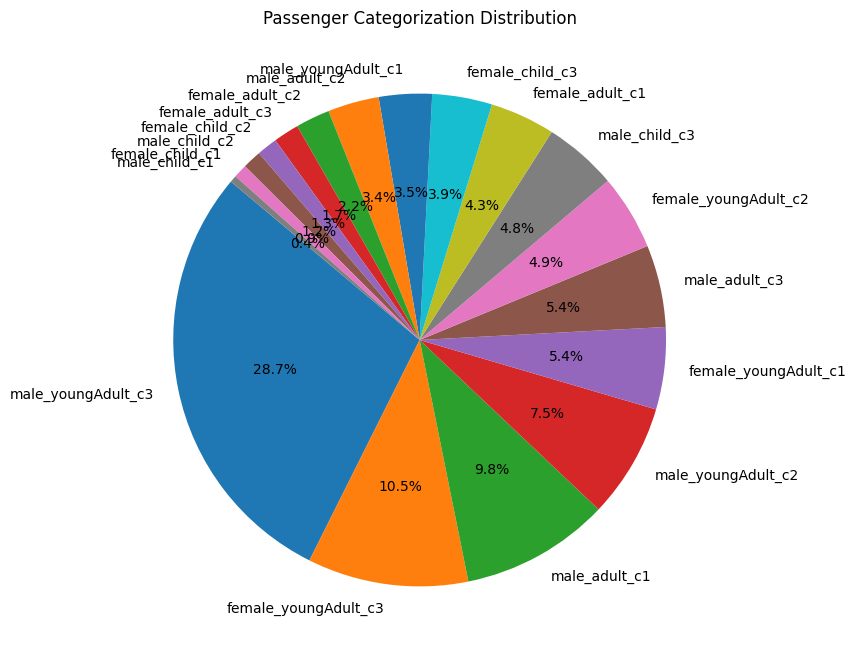

In [125]:
category_counts = X_train['passenger_categorization'].value_counts() 

# Create a pie chart 
plt.figure(figsize=(12, 8)) 
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140) 
plt.title('Passenger Categorization Distribution')
plt.show()

- From the above chart, we can see that male passengers between the ages of 18 and 35 with the  are the most common.
- Interestingly, first class males above 35 are the third most common.
- We will now create our stratified validation set based on this.

In [126]:
from sklearn.model_selection import train_test_split

df_strat_train_set, df_strat_val_set = train_test_split(
    X_train, test_size=0.2, stratify=X_train["passenger_categorization"], 
    random_state=42
)

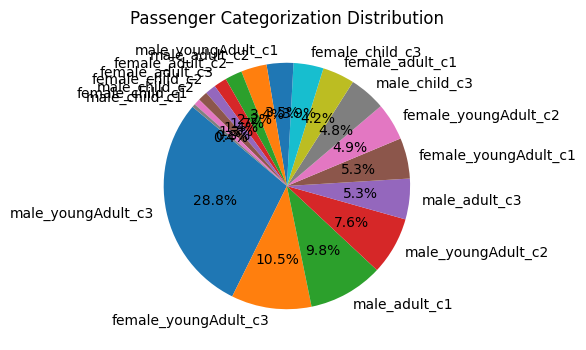

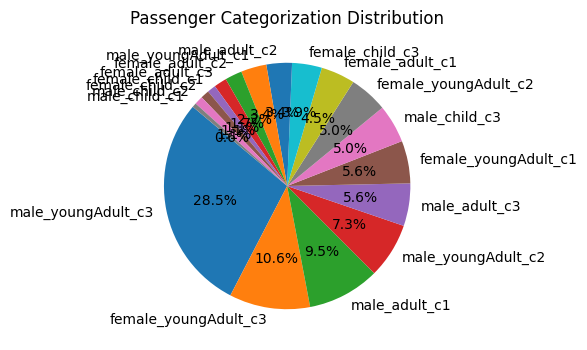

In [127]:
# Checking to make sure the new train and test sets have roughly the same category distribution
category_counts = df_strat_train_set['passenger_categorization'].value_counts() 

# Create a pie chart 
plt.figure(figsize=(6, 4)) 
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140) 
plt.title('Passenger Categorization Distribution')
plt.show()

category_counts = df_strat_val_set['passenger_categorization'].value_counts() 

# Create a pie chart 
plt.figure(figsize=(6, 4)) 
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140) 
plt.title('Passenger Categorization Distribution')
plt.show()

Great, now we can delete the column we created for stratifying!

In [128]:
for df in (df_strat_train_set, df_strat_val_set):
    df.drop("passenger_categorization", axis=1, inplace=True)

In [129]:
df_strat_train_set.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [130]:
# Copy for experimentation
df_titanic = df_strat_train_set.copy()

In [131]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 376 to 855
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [132]:
# Drop the two rows where Embarked is null
df_titanic = df_titanic.dropna(subset=["Embarked"])

In [133]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 710 entries, 376 to 855
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  710 non-null    int64  
 1   Survived     710 non-null    int64  
 2   Pclass       710 non-null    int64  
 3   Name         710 non-null    object 
 4   Sex          710 non-null    object 
 5   Age          710 non-null    float64
 6   SibSp        710 non-null    int64  
 7   Parch        710 non-null    int64  
 8   Ticket       710 non-null    object 
 9   Fare         710 non-null    float64
 10  Cabin        157 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.1+ KB


In [134]:
# Next I want to remove the Cabin, PassengerId, and Name columns altogether
df_titanic = df_titanic.drop(columns=["PassengerId", "Name", "Cabin"])

In [135]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 710 entries, 376 to 855
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  710 non-null    int64  
 1   Pclass    710 non-null    int64  
 2   Sex       710 non-null    object 
 3   Age       710 non-null    float64
 4   SibSp     710 non-null    int64  
 5   Parch     710 non-null    int64  
 6   Ticket    710 non-null    object 
 7   Fare      710 non-null    float64
 8   Embarked  710 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 55.5+ KB


In [136]:
df_titanic_numeric_attrs = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Survived"]
corr_matrix = df_titanic[df_titanic_numeric_attrs].corr()
corr_matrix["Survived"].sort_values(ascending=False)


Survived    1.000000
Fare        0.259180
Parch       0.076372
SibSp      -0.018028
Age        -0.074684
Pclass     -0.306260
Name: Survived, dtype: float64

- Of these attributes, the fare paid and the class of the ticket seem to be the strongest indicators of survival.

#### Handling Categorical Attributes

In [137]:
df_titanic["Embarked"].value_counts()

Embarked
S    510
C    137
Q     63
Name: count, dtype: int64

In [138]:
df_titanic_cat = df_titanic[["Pclass", "Sex", "Embarked"]]

In [139]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
cat_1hot_matrix = one_hot_encoder.fit_transform(df_titanic_cat)

In [140]:
one_hot_encoder.categories_

[array([1, 2, 3]),
 array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object)]

In [145]:
# Creating a dataframe using the new one hot columns
print(one_hot_encoder.get_feature_names_out())
df_titanic_cat_1hot = pd.DataFrame(
    one_hot_encoder.transform()
)

['Pclass_1' 'Pclass_2' 'Pclass_3' 'Sex_female' 'Sex_male' 'Embarked_C'
 'Embarked_Q' 'Embarked_S']


In [141]:
# Now we want to separate the labels
df_strat_train_labels = df_strat_train_set[["Survived"]]
df_strat_train_set = df_strat_train_set.drop(columns=["Survived"])

df_strat_val_labels = df_strat_val_set[["Survived"]]
df_strat_val_set = df_strat_val_set.drop(columns=["Survived"])

In [142]:
print(f"Shape of the stratified training set: {df_strat_train_set.shape} and labels: {df_strat_train_labels.shape}")
print(f"Shape of the stratified test set: {df_strat_val_set.shape} and labels: {df_strat_val_labels.shape}")

Shape of the stratified training set: (712, 11) and labels: (712, 1)
Shape of the stratified test set: (179, 11) and labels: (179, 1)


In [143]:
# This is the final test set which is used to simulate real-world instances of the data
X_test = load_titanic_data("test")
print(X_test.columns)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
